In [1]:
from __future__ import print_function

import math
from sage.functions.all import ceil, floor
from sage.geometry.polyhedron.constructor import Polyhedron
from sage.modules.all import vector
from sage.plot.all import (Color, Graphics,
                           arrow, line, point, rainbow, text)
from sage.plot.plot3d.all import text3d
from sage.rings.all import RDF, QQ
from sage.structure.sage_object import SageObject
from sage.geometry.toric_plotter import ToricPlotter, color_list, label_list

In [2]:
def disk(radius, translation, ray1, ray2):
    # На вход принимает радиус, сдвиг и два ребра
    # Строит круг, если пространство двумерное
    # Cтроит сечение сферы, если пространство трёхмерное
    
    ray1 = vector(RDF, ray1)
    ray2 = vector(RDF, ray2)
    translation = vector(RDF, translation)
    
    vertices_per_radian = 30
    n = ceil(math.pi * vertices_per_radian / 2)
    
    # Если векторы не перпендикулярны, 
    # то строим вектор перпендикулярный первому
    if abs(ray2.dot_product(ray1)) > 1e-12:
        d = ray1.dot_product(ray1) / ray2.dot_product(ray1)
        ray2 = ray1 - d * ray2    
    
    # Находим точки окружности/сечения сферы
    dr1 = (ray2 - ray1) / n
    dr2 = (ray2 + ray1) / n
    points = [ray1 + i * dr1 for i in range(n + 1)]
    points += [ray2 - i * dr2 for i in range(n + 1)]
    points += [-ray1 - i * dr1 for i in range(n + 1)]
    points += [-ray2 + i * dr2 for i in range(n + 1)]
    points = [translation + (radius * pt) / pt.norm() for pt in points]
    return Polyhedron(points, base_ring=QQ)

In [3]:
class PolyhedralToricPlotter(ToricPlotter):
    def __init__(self, all_options, dimension, generators = None, ray_positions = None):
        # Большая часть настройки совпадает с настройкой ToricPlotter 
        super(PolyhedralToricPlotter, self).__init__(all_options, dimension, None)
        if "show_polyhedra" in all_options:
            self.show_polyhedra = all_options["show_polyhedra"]
        else:
            self.show_polyhedra = True
        # Так как лучи не обязаны выходить из центра, 
        # их настройка идёт по новым методам
        if generators is None and ray_positions is not None:
            raise ValueError("Can't specify ray positions "
                             "without their generators")
        if generators is not None:
            self.set_rays(generators, ray_positions, adjust_bounds=True)
        else:
            self.generators = None
            self.ray_positions = None
            self.adjust_options()
    
    def __eq__(self, other):
        #Сравнение
        return type(self) is type(other) and self.__dict__ == other.__dict__
    
    def adjust_options(self):
        # Настройка важных параметров, если они не 
        # определены или нуждаются в корректировке
        super(PolyhedralToricPlotter, self).adjust_options()

    def include_points(self, points, force=False):
        # Если границы не заданы или force=True 
        # меняет границы, если точки не влезают в них
        super(PolyhedralToricPlotter, self).include_points(points, force)

    def set_rays(self, generators, ray_positions = None, adjust_bounds = False):
        # Задание рёбер. Если ray_positions = None рёбра выходят из центра
        # Если adjust_bounds или границы не заданы - задаём границы по точкам
        
        d = self.dimension
        if d == 1:
            generators = [vector(RDF, 2, (gen[0], 0)) for gen in generators]
        else:
            generators = [vector(RDF, d, gen) for gen in generators]
        self.generators = generators
        
        if ray_positions is None:
            ray_positions = [self.origin for gen in generators]
        else:
            if d == 1:
                ray_positions = [vector(RDF, 2, (pos[0], 0)) for pos in ray_positions]
            else:
                ray_positions = [vector(RDF, d, pos) for pos in ray_positions]
        self.ray_positions = ray_positions
        
        bounds = [self.__dict__[bound]
                for bound in ["xmin", "xmax", "ymin", "ymax", "zmin", "zmax"] 
                      if self.__dict__[bound] is not None] 
        if adjust_bounds or len(bounds) < 2 * self.dimension:
            positions = []
            for gen, pos in zip(generators, ray_positions):
                if abs(gen + pos) > abs(pos):
                    positions.append(gen + pos)
                else:
                    positions.append(pos)
            self.include_points(positions, force=True)
            self.adjust_options()
        
        if self.mode == "box":
            #Меняем систему координат. Находим границы в ней. Возвращаемся
            rays = []
            bounds = [self.__dict__[bound]
                for bound in ["xmin", "xmax", "ymin", "ymax", "zmin", "zmax"]] 
            bounds = bounds[:2 * d]
            for gen, pos in zip(generators, ray_positions):
                factors = []
                for i, (gen_i, pos_i) in enumerate(zip(gen, pos)):
                        factors.append(gen_i / (bounds[2 * i] - pos_i))
                        factors.append(gen_i / (bounds[2 * i + 1] - pos_i))
                rays.append(gen / max(factors) + pos)

        elif self.mode == "generators":
            rays = [pos + gen for gen, pos in zip(generators, ray_positions)]

        elif self.mode == "round":
            # Находим пересечения прямой с окружностью/сферой
            # Сначала находим точку ближе всего лежащую к центру
            # Затем находим расстояние от неё до точек пересечения
            # Находим нужную точку
            r = self.radius
            rays = []
            for gen, pos in zip(generators, ray_positions):
                step1 = - pos.dot_product(gen) / gen.dot_product(gen)
                nearest = pos + gen * step1

                step2 = (r**2 - nearest.dot_product(nearest)) ** 0.5
                step2 = step2 / gen.norm()
                    
                rays.append(nearest + gen * step2)
        self.rays = rays
    
    # Методы отрисовки
    def plot_points(self, points):
        return super(PolyhedralToricPlotter, self).plot_points(points)

    def plot_lattice(self):
        return super(PolyhedralToricPlotter, self).plot_lattice()
        
    def plot_labels(self, labels, positions):
        return super(PolyhedralToricPlotter, self).plot_labels(labels, positions)
    
    def plot_ray_labels(self):
        origins = self.ray_positions
        ends = self.rays
        rays = dict()
        label_positions = []
        for origin, end in zip(origins, ends):
            v = tuple(list(end))
            if v not in rays:
                rays[v] = (end-origin)/(end - origin).norm()
                label_positions.append(end + 0.25 * rays[v])
        
        return self.plot_labels(self.ray_label, label_positions)
        
    def plot_rays(self):
        result = Graphics()
        origins = self.ray_positions
        ends = self.rays
        if not ends or not self.show_rays:
            return result
        extra_options = self.extra_options
        colors = color_list(self.ray_color, len(ends))
        thickness = self.ray_thickness
        zorder = self.ray_zorder
        for origin, end, color in  zip(origins, ends, colors):
            result += line([origin, end], color=color, thickness=thickness,
                           zorder=zorder, **extra_options)
        result += self.plot_ray_labels()
        return result 
    
    def plot_generators(self):
        result = Graphics()
        generators = self.generators
        origins = self.ray_positions
        ends = self.rays
        if not generators or not self.show_generators:
            return result
        
        colors = color_list(self.generator_color, len(generators))
        d = self.dimension
        extra_options = self.extra_options
        thickness = self.generator_thickness
        zorder = self.generator_zorder
        for gen, origin, end, color in zip(generators, origins, 
                                           ends, colors):
            if (end - origin).norm() < gen.norm():
                result += line([origin, end],
                                color=color, thickness=thickness,
                                zorder=zorder, **extra_options)
            else:
                if d <= 2:
                    result += arrow(origin, origin + gen,
                                    color=color, width=thickness,
                                    arrowsize=thickness + 1,
                                    zorder=zorder, **extra_options)
                else:
                    result += line([origin, origin + gen], 
                                    arrow_head=True, color=color, 
                                    thickness=thickness, zorder=zorder, 
                                    **extra_options)
        return result
            
    def plot_walls(self, walls, color = None):
        result = Graphics()
        if not walls or not self.show_walls:
            return result
        
        extra_options = self.extra_options
        mode = self.mode
        alpha = self.wall_alpha
        if color is None:
            colors = color_list(self.wall_color, len(walls))
        else:
            colors = color_list(color, len(walls))
        zorder = self.wall_zorder
        if mode == "box":
            if self.dimension <= 2:
                ieqs = [(self.xmax, -1, 0), (- self.xmin, 1, 0),
                        (self.ymax, 0, -1), (- self.ymin, 0, 1)]
            else:
                ieqs = [(self.xmax, -1, 0, 0), (- self.xmin, 1, 0, 0),
                        (self.ymax, 0, -1, 0), (- self.ymin, 0, 1, 0),
                        (self.zmax, 0, 0, -1), (- self.zmin, 0, 0, 1)]
            box = Polyhedron(ieqs=ieqs, base_ring=QQ)
            
            for wall, color in zip(walls, colors):
                if wall.dim() > 2:
                    raise ValueError("Wall dimension is greater than 2"
                        "Got %s!" % (wall))
                result += box.intersection(wall).render_solid(
                    alpha=alpha, color=color, zorder=zorder, **extra_options)
        elif mode == "generators":
            for wall, color in zip(walls, colors):
                if wall.dim() > 2:
                    raise ValueError("Wall dimension is greater than 2"
                            "Got %s!" % (wall))
                result += wall.render_solid(
                    alpha=alpha, color=color, zorder=zorder, **extra_options)
        else:        
            for wall, color in zip(walls, colors):
                if wall.dim() > 2:
                    raise ValueError("Wall dimension is greater than 2"
                            "Got %s!" % (wall))

                vertices = [vector(RDF, v) for v in wall.vertices()]
                rays = [vector(RDF, r) for r in wall.rays()]
                lines = [vector(RDF, l) for l in wall.lines()]
                if len(rays) == 0 and len(lines) == 0:
                    # Обычный замкнутый выпуклый многогранник
                    result += wall.render_solid(
                        alpha=alpha, color=color, zorder=zorder, **extra_options)
                else:
                    if self.dimension <= 2:
                        d = disk(self.radius, (0,0), (1,0), (0,1))
                    else:
                        # Если рёбер недостаточно - делаем их
                        if len(lines) == 1:
                            rays.append(lines[0])
                        if len(rays) == 1:
                            rays.append(vertices[1] - vertices[0])
                        # Находим сечение сферы плоскостью содержащей грань
                        # Сначала находим нормаль плоскости
                        # Находим расстояние от центра до плоскости
                        # Находим радиус сечения и сдвиг от центра
                        normal = rays[0].cross_product(rays[1])
                        dist = normal.dot_product(vertices[1])
                        t = dist * (normal / normal.norm())
                        r = sqrt(self.radius**2 - dist**2)
                        d = disk(r, t, rays[0], rays[1])
                    # Находим пересечение круга/сечения с гранью. 
                    # Базовое кольцо QQ, потому что RDF даёт 
                    # ошибки с точностью
                    qq_wall = Polyhedron(vertices, rays, lines, base_ring=QQ)
                    result += d.intersection(qq_wall).render_solid(
                        alpha=alpha, color=color, zorder=zorder, **extra_options)
        return result
    
    def plot_polyhedra(self, polyhedra):
        result = Graphics()
        
        if not polyhedra or not self.show_polyhedra:
            return result

        if self.dimension == 2:
            return result + self.plot_walls(polyhedra)
        
        colors = color_list(self.wall_color, len(polyhedra))
        for polyhedron, color in zip(polyhedra, colors):
            walls = [face.as_polyhedron() for face in polyhedron.faces(self.dimension - 1)]
            result += self.plot_walls(walls, color)
        return result

In [4]:
tp = PolyhedralToricPlotter({"mode":"generators"}, 3)
tp.plot_polyhedra([Polyhedron([(1,0,0), (0,0,1)],[(1,2,0),(1,3,-1)])]) + tp.plot_lattice()

Graphics3d Object

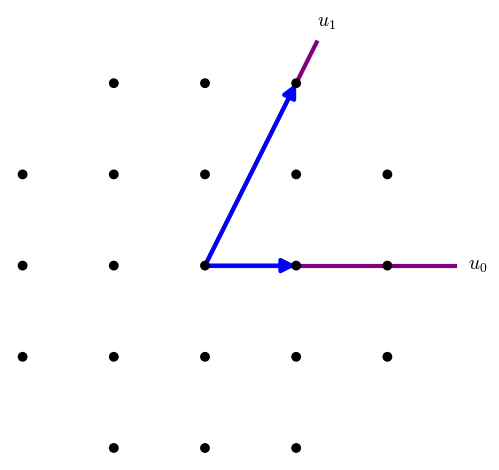

In [5]:
tp = PolyhedralToricPlotter({}, 2, [(1,0), (1,2)])
tp.plot_lattice() + tp.plot_rays() + tp.plot_generators()

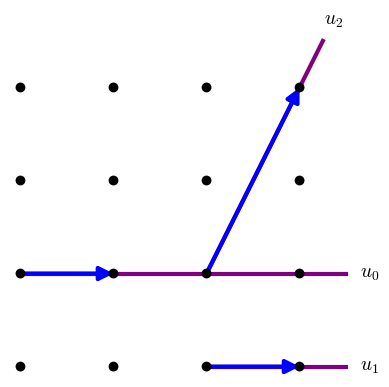

In [6]:
tp = PolyhedralToricPlotter({"mode":"box"}, 2, [(1,0), (1,0), (1,2)], [(-2,1),(0,0),(0,1)])
tp.plot_lattice() + tp.plot_rays() + tp.plot_generators()

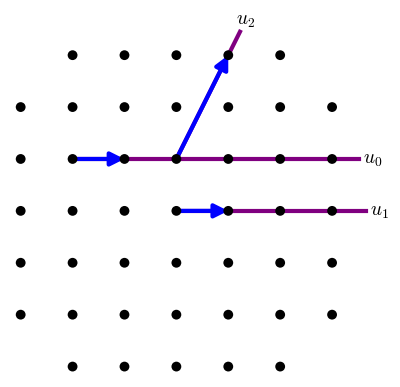

In [7]:
tp.mode = "round"
tp.set_rays(tp.generators, tp.ray_positions, True)
tp.plot_lattice() + tp.plot_rays() + tp.plot_generators()

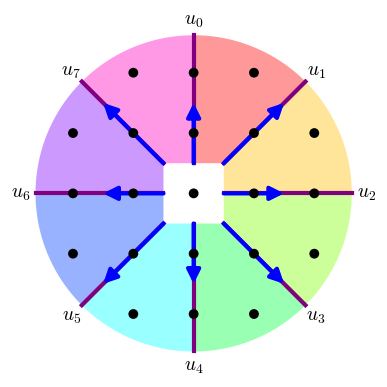

In [8]:
rays = [(0,1), (1,1), (1,0), (1,-1), (0,-1), (-1,-1), (-1,0), (-1,1)]
points = [(0,0.5), (0.5,0.5), (0.5,0), (0.5,-0.5), (0,-0.5), (-0.5,-0.5), (-0.5,0), (-0.5,0.5)]
polyhedra = [Polyhedron([points[i], points[(i + 1) % 8]], [rays[i], rays[(i + 1) % 8]]) for i in range(8)]

tp = PolyhedralToricPlotter({"mode":"round"}, 2, rays, points)
tp.plot_polyhedra(polyhedra) + tp.plot_lattice() + tp.plot_rays() + tp.plot_generators()

In [9]:
rays = [(1,0,0), (0,1,0), (0,0,1), (-1,0,0), (0,-1,0), (0,0,-1)]
points = [(1,0,0), (0,1,0), (0,0,1), (-1,0,0), (0,-1,0), (0,0,-1)]
polyhedra = [Polyhedron([points[i], points[(i + 1) % 6], points[(i + 2) % 6]], 
                        [rays[i], rays[(i + 1) % 6], rays[(i + 2) % 6]]) for i in range(6)]

tp = PolyhedralToricPlotter({"mode":"generators"}, 3, rays, points)
tp.plot_polyhedra(polyhedra) + tp.plot_lattice() + tp.plot_rays() + tp.plot_generators()

Graphics3d Object

In [10]:
tp.mode="box"
tp.plot_polyhedra(polyhedra) + tp.plot_lattice() + tp.plot_rays() + tp.plot_generators()

Graphics3d Object

In [11]:
tp.mode="round"
tp.plot_polyhedra(polyhedra) + tp.plot_lattice() + tp.plot_rays() + tp.plot_generators()

Graphics3d Object

In [12]:
tp.plot_polyhedra([polyhedra[0]]) + tp.plot_rays() + tp.plot_generators()

Graphics3d Object

In [13]:
#rays = [(1,0,0), (0,1,0), (0,0,1), (-1,0,0), (0,-1,0), (0,0,-1)]
points = [(1,0,0), (0,1,0), (0,0,1), (-1,0,0), (0,-1,0), (0,0,-1)]
tp = PolyhedralToricPlotter({}, 3)
tp.plot_polyhedra([Polyhedron(points)])

Graphics3d Object

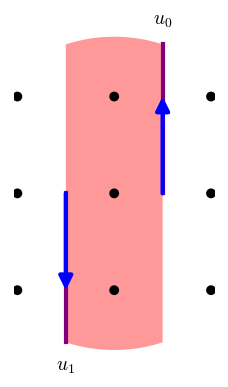

In [14]:
rays = [(0,1), (0, -1)]
points = [(0.5, 0), (-0.5, 0)]
polyhedra = [Polyhedron(points, rays)]

tp = PolyhedralToricPlotter({"mode":"round"}, 2, rays, points)
tp.plot_polyhedra(polyhedra) + tp.plot_lattice() + tp.plot_rays() + tp.plot_generators()

In [15]:
from __future__ import print_function

import sys

from sage.functions.all import factorial
from sage.geometry.cone import Cone, is_Cone
from sage.geometry.fan import Fan
from sage.modules.free_module_element import vector
from sage.rings.all import PolynomialRing, ZZ, QQ, QuotientRing
_Fields = Fields()

#from PolyhedralToricPlotter import *

In [16]:
class PolyhedralSubdivision():
    def __init__(self, polyhedra, lattice=None, base_ring=QQ, check=False):
        # Строим срез как список многогранников, а также строим разбиение 
        # многогранников на сумму Минковского замкнутого выпуклого 
        # многогранника и конуса. Если check = True проверяем, что на 
        # вход пришли выпуклые многогранники одинаковой размерности,
        # размерность которых совпадает с размерностью пространства и
        # пересечение любых двух из них - грань обоих.
        if not polyhedra:
            raise ValueError("You can not construct a polyhedral"
                             "subdivision without polyhedra!")
        try:
            polyhedra = list(polyhedra)
        except TypeError:
            raise TypeError("Polyhedra must be given as an iterable!"
                            "\nGot: %s" % polyhedra)
        if lattice is None:
            lattice = ToricLattice(polyhedra[0].ambient_dim())
        dim = lattice.dimension()
        
        polyhedral_bases = []
        cones = []
        for polyhedron in polyhedra:
            if check:
                if polyhedron.ambient_dim() != dim:
                    raise ValueError("Polyhedra have different dimensions"
                            "(%s and %s)!" % 
                            (lattice.dimension(), polyhedron.ambient_dim()))
                if polyhedron.dim() != dim:
                    raise ValueError("Not all polyhedra have pointed tailcone!"
                            "\nGot%s" % (polyhedron))
            polyhedral_bases.append(Polyhedron(polyhedron.vertices_list(), 
                                               base_ring=base_ring))
            cones.append(Cone(polyhedron.rays_list()))
                      
            def is_face(candidate, polyhedron):
                for face in polyhedron.faces(intersection.dim()):
                    if candidate.n_vertices()==face.n_vertices() and\
                        candidate.n_rays()==face.n_rays():
                        if candidate==face.as_polyhedron():
                            return True
                return False
        if check:
            for i in range(len(polyhedra)):
                for j in range(i+1,len(polyhedra)):
                    intersection = polyhedra[i].intersection(polyhedra[j])
                    if intersection.dim()!=-1:
                        if not is_face(intersection, polyhedra[i]) or\
                            not is_face(intersection, polyhedra[j]):
                                raise ValueError("Polyhedra intersection is not"
                                    "face of (%s and %s) -th polyhedra!" %  (i, j))
        
        self._polyhedra = [Polyhedron(p.vertices(), p.rays(), 
                                     p.lines(), base_ring=base_ring)
                          for p in polyhedra]
        self._polyhedral_bases = polyhedral_bases
        self._cones = cones
        self._lattice = lattice
        self._base_ring = base_ring
    
    def __eq__(self, right):
        if not isinstance(right, PolyhedralSubdivision):
            return False
        if self._lattice != right.lattice() or\
            self._base_ring != right.base_ring():
            return False
        for polyhedron in self._polyhedra:
            match_founded = False
            for r_polyhedron in right.polyhedra():
                if polyhedron == r_polyhedron:
                    match_founded = True
                    break
            if not match_founded:
                return False
        return True

    def __ne__(self, other):
        return not (self == other)

    def __hash__(self):
        return hash((self._cones, self._polyhedral_bases, self._base_ring))
    
    # Базовые методы для получения хранящихся значений и размерностей
    
    def dimension(self):
        return self._lattice.dimension()

    def dim(self):
        return self.dimension()
    
    def base_ring(self):
        return self._base_ring
    
    def lattice(self):
        return self._lattice
    
    def tailfan(self):
        return Fan(self._cones, discard_faces=True)
    
    def n_tailcones(self):
        return len(self._cones)
    
    def tailcones(self):
        return self._cones
    
    def tailcone(self, i):
        return self._cones[i]
    
    def polyhedra(self):
        return self._polyhedra
    
    def polyhedron(self, i):
        return self._polyhedra[i]
    
    def polyhedral_bases(self):
        return self._polyhedral_bases
    
    def polyhedral_base(self, i):
        return self._polyhedral_bases[i]
    
    def polyhedron_with_tailcone(self, tailcone):
        for i, cone in enumerate(self._cones):
            if cone == tailcone:
                return self._polyhedra[i]
        raise ValueError("There is no such cone in tailfan!")
            
    
    def is_complete(self):
        # Проверка на полноту. Пользуемся тем, что любая грань 
        # максимальной размерности - грань не более, чем 2 
        # многогранников, а если разбиение полное, то ровно 2
        if 'complete' not in self.__dict__:
            self.complete = True
            faces = dict()
            for polyhedron in self._polyhedra:
                for face in polyhedron.faces(self.dim() - 1):
                    vertices = tuple(tuple(v) for v in face.vertices())
                    rays = tuple(tuple(r) for r in face.rays())
                    key = (vertices, rays)
                    if key not in faces:
                        faces[key] = 1
                    else:
                        faces[key] += 1
            for face in faces:
                if faces[face] != 2:
                    self.complete = False
        return self.complete
    
    def plot(self, options = {}):
        # Строим отрисовщик на основе уникальных рёбер
        # Рисуем срез
        if 'plotter' not in self.__dict__:
            vr = set()
            for polyhedron in self._polyhedra:
                for face in polyhedron.faces(1):
                    # Если не отрезок, то луч
                    if face.n_rays() != 0:
                        v, r = tuple(face.vertices()[0]), tuple(face.rays()[0])
                        vr.add((v, r))

            generators, gen_positions = [], []
            for v, r in vr:
                generators.append(r)
                gen_positions.append(v)
            self.plotter = PolyhedralToricPlotter(options, self.dim(), 
                                        generators, gen_positions)

        return self.plotter.plot_polyhedra(self._polyhedra) +\
                self.plotter.plot_lattice() +\
                self.plotter.plot_rays() +\
                self.plotter.plot_generators()

In [17]:
import time

start = time.time()
p1 = Polyhedron([(0, 0), (-1, 0)], [(-1,1), (2, 2)])
p2 = Polyhedron([(0,0)], [(2, 2), (1, -1)])
p3 = Polyhedron([(0, 0), (-1,0)], [(1, -1), (-2, -2)])
p4 = Polyhedron([(-1, 0)], [(-2,-2), (-1, 1)])
p5 = Polyhedron([(0, 0)], [(-1,1), (2, 2)])
p6 = Polyhedron([(0, 0), (0,-1)], [(1,-1), (2, 2)])
p7 = Polyhedron([(0, - 1)], [(1,-1), (-2, -2)])
p8 = Polyhedron([(0, 0), (0, - 1)], [(-1,1), (-1, -1)])
p9 = Polyhedron([(0.5, 0.5)], [(-1,1), (2, 2)])
p10 = Polyhedron([(0.5, 0.5)], [(2, 2), (1, -1)])
p11 = Polyhedron([(0.5, 0.5)], [(1, -1), (-2, -2)])
p12 = Polyhedron([(0.5, 0.5)], [(-1,1), (-2, -2)])
print(time.time()-start)

8.801384210586548


In [18]:
start = time.time()
slice1 = PolyhedralSubdivision([p1,p2,p3,p4])
print(time.time()-start)
start = time.time()
slice2 = PolyhedralSubdivision([p5,p6,p7,p8])
print(time.time()-start)
start = time.time()
slice3 = PolyhedralSubdivision([p9,p10,p11,p12])
print(time.time()-start)

0.024263620376586914
0.0052030086517333984
0.005105733871459961


In [19]:
start = time.time()
print(slice1.is_complete())
print(time.time()-start)
start = time.time()
print(slice2.is_complete())
print(time.time()-start)
start = time.time()
print(slice3.is_complete())
print(time.time()-start)

True
0.01204061508178711
True
0.01181650161743164
True
0.008855819702148438


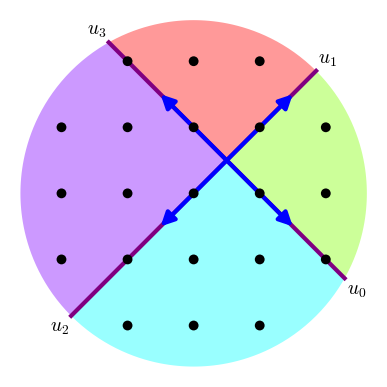

In [20]:
slice3.plot()

In [21]:
# from PolyhedralSubdivision import *

class fDivisor():
    def __init__(self, points, slices, deg=None, 
                 lattice=None, base_ring=QQ, check=True):
        # Строим f-Divisor, как список точек с соответствующими им срезами и deg
        # Если check = True проверяем, что на вход пришли срезы с одинаковыми 
        # хвостовыми веерами и deg корректно задан. Если же он не задан, 
        # то строим его по срезам, если возможно. Если нельзя, сообщаем об этом
        if not slices:
            raise ValueError("You can't construct a f-divisor"
                    "without divisoral fan!")
        if not isinstance(slices, list):
            try:
                slices = list(slices)
            except TypeError:
                raise TypeError(
                    "Slices must be given as an iterable!"
                    "\nGot: %s" % slices)
        if not isinstance(points, list):
            try:
                points = list(points)
            except TypeError:
                raise TypeError(
                    "Points must be given as an iterable!"
                    "\nGot: %s" % points)
        if len(slices) != len(points):
            raise ValueError(
                    "Number of points should match number of slices"
                    "\nGot: %s points and %s slices!" % (len(points), len(slices)))
        
        points = [tuple(p) for p in points]
        
        if lattice is None:
            lattice = ToricLattice(slices[0].dim())
        
        if check and deg is not None:
                if not isinstance(deg, PolyhedralSubdivision):
                    raise TypeError(
                    "Deg must be given as polyhedral subdivisions!"
                    "\nGot: %s" % sl)
                
                if deg.dim() != lattice.dimension():
                    raise ValueError("Deg belong to different space "
                        "(%s and %s)!" % 
                        (lattice.dimension(), deg.dim()))
                    
        self._tailcones = [cone for cone in slices[0].tailfan()]
        for sl in slices:
            if check:
                if not isinstance(sl, PolyhedralSubdivision):
                    raise TypeError(
                    "Slices must be given as polyhedral subdivisions!"
                    "\nGot: %s" % sl)
                
                if sl.dim() != lattice.dimension():
                    raise ValueError("Slices belong to different spaces "
                        "(%s and %s)!" % 
                        (lattice.dimension(), sl.dim()))
                if not self.tailfan().is_equivalent(sl.tailfan()):
                    raise ValueError("Slices have different tailfan "
                        "(%s and %s)!" % 
                        (self.tailfan(), sl.tailfan()))
        
        # Так как хвостовые конусы одинаковые, достаточно сравнивать 
        # замкнутые выпуклые многогранники из сумм Минковского
        dim = lattice.dimension()
        if check and deg is not None: 
            check_deg = [Polyhedron([[0] * dim], base_ring=base_ring) 
                         for _ in range(deg.n_tailcones())]
            for i, tailcone in enumerate(deg.tailcones()):
                for sl in slices:
                    for cone, base in zip(sl.tailcones(),sl.polyhedral_bases()):
                        if cone.is_equivalent(tailcone):
                            check_deg[i] = check_deg[i].minkowski_sum(base)
            for d, right_d in zip(deg.polyhedral_bases(), check_deg):
                if d != right_d:
                    raise ValueError("Slices don't give f-divisor!")
        
        if deg is None:
            deg = [Polyhedron([[0] * lattice.dimension()], base_ring=base_ring) 
                   for cone in self.tailcones()]
            for i, tailcone in enumerate(self.tailcones()):
                for sl in slices:
                    for cone, base in zip(sl.tailcones(), sl.polyhedral_bases()):
                        if cone.is_equivalent(tailcone):
                            deg[i] = deg[i].minkowski_sum(base)
                deg[i] = deg[i].minkowski_sum(Polyhedron([[0] * dim], 
                                                [tuple(r) for r in tailcone]))
                if deg[i].intersection(Polyhedron([[0] * dim], 
                                        [tuple(r) for r in tailcone])) != deg[i]:
                    raise ValueError("Slices don't give correct deg!")
            deg = PolyhedralSubdivision(deg, base_ring=base_ring)

        self._points = points
        self._slices = slices
        self._deg = deg
        self._lattice = lattice
        self._base_ring = base_ring
    
    def __eq__(self, right):
        if not isinstance(right, fDivisor):
            return False
        if self._lattice != right.lattice() or\
            self._base_ring != right.base_ring() or\
            self._points != right.points() or \
            not self._tailcones.is_equivalent(right.tailcones()):
            return False
        for sl in self._slices:
            match_founded = False
            for rsl in right.slices():
                if sl == rsl:
                    match_founded = True
                    break
            if not match_founded:
                return False
        return True

    def __ne__(self, other):
        return not (self == other)

    def __hash__(self):
        return hash((self._points, self._slices, self._base_ring))
      
    # Базовые методы для получения хранящихся значений и размерностей
    
    def dimension(self):
        return self._lattice.dimension()

    def dim(self):
        return self.dimension()
    
    def base_ring(self):
        return self._base_ring
    
    def lattice(self):
        return self._lattice
    
    def tailfan(self):
        return Fan(self._tailcones)
    
    def tailcones(self):
        return self._tailcones
    
    def tailcone(self, i):
        return self._tailcones.cones(i)
    
    def deg(self):
        return self._deg
    
    def points(self):
        return self._points
    
    def slice(self, i):
        return (self._point[i], self._slices[i])
    
    def slices(self):
        return self._slices

    def is_smooth(self):
        # Проверка на гладкость.
        # Сначала проверяем сложные случаи.
        # Для этого нахоим многогранники не являющийся сдвигом по решётке
        # Если их не более 2, то строим конус и проверяем его на гладкость
        if 'smooth' not in self.__dict__:
            self.smooth = False
            cones = [cone for cone in self.tailcones()]
            for deg_cone in self._deg.tailcones():
                for cone in cones:
                    rays = [tuple(list(r)+[0]) for r in cone.rays()]
                    if cone.is_equivalent(deg_cone):
                        cones.remove(cone)
                        polyhedra = []
                        for sl in self._slices:
                            for p, c in zip(sl.polyhedral_bases(), sl.tailcones()):
                                if c.is_equivalent(cone):
                                    polyhedra.append(p)
                        k = 0
                        p_neg = None
                        for p in polyhedra:
                            if p.n_vertices() > 1:
                                k += 1
                                p_neg = p
                            else:
                                try:
                                    vertex = self._lattice(p.vertices_list()[0])
                                except TypeError:
                                    p_neg = p
                                    k+=1
                        
                        if not 0<k<3:
                            return self.smooth
                    
                        rays += [tuple(list(v)+[-1]) for v in p_neg.vertices()]
                
                        p_pos = Polyhedron([tuple([0]*self.dim())])
                        for p in polyhedra:
                            if p!=p_neg:
                                p_pos = p_pos.minkowski_sum(p)
                        
                        rays += [tuple(list(v)+[1]) for v in p_pos.vertices()]
                
                        result_cone = Cone(rays)
                        if not result_cone.is_simplicial():
                            return self.smooth
                        m = result_cone.rays().matrix()
                        if abs(m.determinant())!=1:
                            return self.smooth
                        break

            # Проверяем оставшиеся простые случаи
            # Строим конусы и проверяем их гладкость
            for cone in cones:
                for sl in self._slices:
                    rays = [tuple(list(r)+[0]) for r in cone.rays()]
                    for p, c in zip(sl.polyhedral_bases(), sl.tailcones()):
                        if c.is_equivalent(cone):
                            rays += [tuple(list(v)+[1]) for v in p.vertices()]
                            break
                    
                    result_cone = Cone(rays)
                    if not result_cone.is_simplicial():
                        return self.smooth
                    m = result_cone.rays().matrix()
                    if abs(m.determinant())!=1:
                        return self.smooth
            self.smooth = True
        return self.smooth
    
    def is_complete(self):
        #Проверка на полноту
        if 'complete' not in self.__dict__:
            self.complete = True
            for subdivision in self._slices:
                if not subdivision.is_complete():
                    self.complete = False
                    break
        return self.complete
 
    def coordinate_ring(self):
        #Строим кольцо Кокса
        if "_coordinate_ring" not in self.__dict__:
            
            # Находим все точки срезов
            sl_vertices = {point: set() for point in self.points()}
            for point, sl in zip(self.points(), self.slices()):
                for pb in sl.polyhedral_bases():
                    for v in pb.vertices():
                        sl_vertices[point].add(tuple(v))
            vertices = sum([sorted([(p, v) for v in sl_vertices[p]])
                            for p in sl_vertices], [])
            vertices = {t : i for i, t in enumerate(vertices)}
            
            # Находим множители точек 
            mu = []
            for point, vertex in vertices:
                c = Cone([vertex])
                if list(c.rays()) == []:
                    mu.append(1)
                else:
                    normalized_vertex = list(c.rays()[0])
                    v, nv = vector(vertex), vector(normalized_vertex)
                    mu.append(max(1, nv.dot_product(v) / v.dot_product(v)))
            
            #Строим многочлены идеала
            ideal_polynomials = []
            for point in sl_vertices:
                sl_vertices[point] = [(v, 't' + str(vertices[(point, v)])) 
                                      for v in sorted(list(sl_vertices[point]))]
                sl_vertices[point] = [s + "^" + str(mu[vertices[(point, v)]])
                                      if mu[vertices[(point, v)]] != 1 else s 
                                      for v, s in sl_vertices[point]]
                sl_vertices[point] = "*".join(sl_vertices[point])

            a = sl_vertices[(0,1)]
            b = sl_vertices[(1,0)]
            for point in sl_vertices:
                if point != (0, 1) and point != (1, 0):
                    ideal_polynomials.append("+".join([a, 
                                                "*".join([str(point[0]), b]), 
                                                sl_vertices[point]]))
            
            # Находим лучи не пересекающиеся с deg
            rays = {tuple(ray): False for ray in self.tailfan().rays()}
            for polyhedron in self.deg().polyhedra():
                for r in polyhedron.faces(1):
                    if r.n_rays() != 0:
                        if sum([abs(e) for e in r.vertices()[0]]) == 0 or\
                        Cone(r.vertices()).is_equivalent(Cone(r.rays())):
                            rays[tuple(r.rays()[0])] = True
            rays = [ray for ray in rays if not rays[ray]]
            
            #Строим кольцо частных
            R = PolynomialRing(self.base_ring(), 
                               len(vertices) + len(rays), 
                               var_array=['t'])
            I = R.ideal([R(p) for p in ideal_polynomials])
            
            self._coordinate_ring = QuotientRing(R, I)
        return self._coordinate_ring
    
    def plot(self, i= -1, options={}):
        # Рисуем срез или deg
        if i == -1:
            return self._deg.plot(options)
        else:
            return self._slices[i].plot(options)

In [22]:
start = time.time()
f= fDivisor([(1,0),(0,1),(1,1)],[slice1, slice2, slice3])
print(time.time()-start)

0.09159660339355469


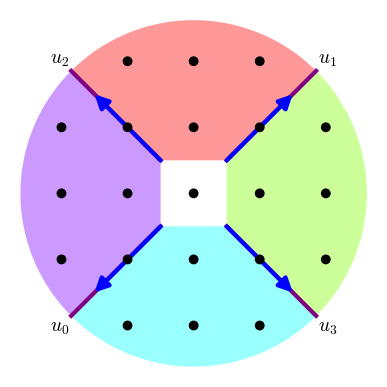

In [23]:
f.plot(-1)

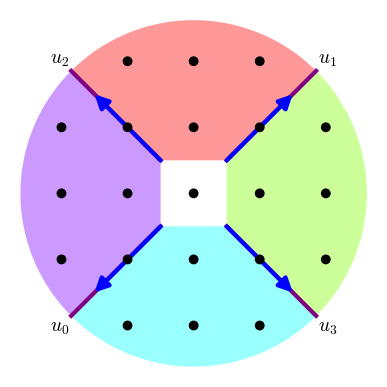

In [24]:
f = fDivisor([(1,0),(0,1),(1,1)],[slice1, slice2, slice3], f.deg())
f.plot(-1)

In [25]:
start = time.time()
print(f.is_smooth())
print(time.time()-start)

True
0.02908015251159668


In [26]:
f.coordinate_ring()

Quotient of Multivariate Polynomial Ring in t0, t1, t2, t3, t4 over Rational Field by the ideal (t0*t1 + t2*t3 + t4^2)

In [27]:
p = [(0,0), (-0.5,0), (-1,0), (0,-0.5), (0,-1), (0.5,0.5)]
r = [(1,0), (1,-1), (0,-1), (-1,-1), (-1,0), (-1,1), (0,1), (1,1)]

In [28]:
import time
start = time.time()
p1 = Polyhedron([p[0], p[1]], [r[6], r[7]])
p2 = Polyhedron([p[0]], [r[7], r[0]])
p3 = Polyhedron([p[0]], [r[0], r[1]])
p4 = Polyhedron([p[0], p[1]], [r[1], r[2]])
p5 = Polyhedron([p[1], p[2]], [r[2], r[3]])
p6 = Polyhedron([p[2]], [r[3], r[4]])
p7 = Polyhedron([p[2]], [r[4], r[5]])
p8 = Polyhedron([p[1], p[2]], [r[5], r[6]])
p9 = Polyhedron([p[0]], [r[6], r[7]])
p10 = Polyhedron([p[0], p[3]], [r[7], r[0]])
p11 = Polyhedron([p[3], p[4]], [r[0], r[1]])
p12 = Polyhedron([p[4]], [r[1], r[2]])
p13 = Polyhedron([p[4]], [r[2], r[3]])
p14 = Polyhedron([p[3], p[4]], [r[3], r[4]])
p15 = Polyhedron([p[0], p[3]], [r[4], r[5]])
p16 = Polyhedron([p[0]], [r[5], r[6]])
p17 = Polyhedron([p[5]], [r[6], r[7]])
p18 = Polyhedron([p[5]], [r[7], r[0]])
p19 = Polyhedron([p[5]], [r[0], r[1]])
p20 = Polyhedron([p[5]], [r[1], r[2]])
p21 = Polyhedron([p[5]], [r[2], r[3]])
p22 = Polyhedron([p[5]], [r[3], r[4]])
p23 = Polyhedron([p[5]], [r[4], r[5]])
p24 = Polyhedron([p[5]], [r[5], r[6]])
print(time.time()-start)

33.24665880203247


In [29]:
start = time.time()
slice1 = PolyhedralSubdivision([p1,p2,p3,p4,p5,p6,p7,p8])
print(time.time()-start)
start = time.time()
slice2 = PolyhedralSubdivision([p9,p10,p11,p12,p13,p14,p15,p16])
print(time.time()-start)
start = time.time()
slice3 = PolyhedralSubdivision([p17,p18,p19,p20,p21,p22,p23,p24])
print(time.time()-start)

0.011681556701660156
0.008632898330688477
0.009245634078979492


In [30]:
start = time.time()
f = fDivisor([(1,0), (0,1), (1,1)], [slice1, slice2, slice3])
print(time.time() - start)

0.10135960578918457


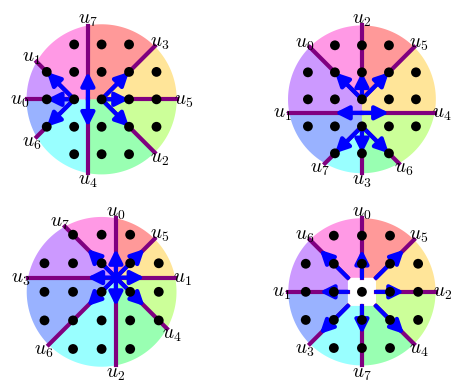

In [31]:
graphics_array([[f.plot(0), f.plot(1)], [f.plot(2), f.plot(-1)]])

In [32]:
print(f.is_smooth())
print(f.is_complete())
print(f.coordinate_ring())

True
True
Quotient of Multivariate Polynomial Ring in t0, t1, t2, t3, t4, t5, t6 over Rational Field by the ideal (t0*t1^2*t2 + t3*t4^2*t5 + t6^2)


In [33]:
p = [(0,0), (-1,0), (0,0), (0,-1), (0.5,0.5)]
r = [(1,-1), (-1,-1), (-1,1), (0,1), (1,1)]

In [34]:
import time
start = time.time()
p1 = Polyhedron([p[0]], [r[3], r[4]])
p2 = Polyhedron([p[0]], [r[4], r[0]])
p3 = Polyhedron([p[0], p[1]], [r[0], r[1]])
p4 = Polyhedron([p[1]], [r[1], r[2]])
p5 = Polyhedron([p[1]], [r[2], r[3]])
p6 = Polyhedron([p[0], p[1]], [r[3]])
p7 = Polyhedron([p[2]], [r[3], r[4]])
p8 = Polyhedron([p[2], p[3]], [r[4], r[0]])
p9 = Polyhedron([p[3]], [r[0], r[1]])
p10 = Polyhedron([p[2], p[3]], [r[1], r[2]])
p11 = Polyhedron([p[2]], [r[2], r[3]])
p12 = Polyhedron([p[4]], [r[3], r[4]])
p13 = Polyhedron([p[4]], [r[4], r[0]])
p14 = Polyhedron([p[4]], [r[0], r[1]])
p15 = Polyhedron([p[4]], [r[1], r[2]])
p16 = Polyhedron([p[4]], [r[2], r[3]])
print(time.time()-start)

11.774036645889282


In [35]:
start = time.time()
slice4 = PolyhedralSubdivision([p1,p2,p3,p4,p5,p6])
print(time.time()-start)
start = time.time()
slice5 = PolyhedralSubdivision([p7,p8,p9,p10,p11])
print(time.time()-start)
start = time.time()
slice6 = PolyhedralSubdivision([p12,p13,p14,p15,p16])
print(time.time()-start)

0.0072040557861328125
0.0056915283203125
0.00748753547668457


In [36]:
start = time.time()
f = fDivisor([(1,0), (0,1), (1,1)], [slice4, slice5, slice6])
print(time.time() - start)

0.05870532989501953


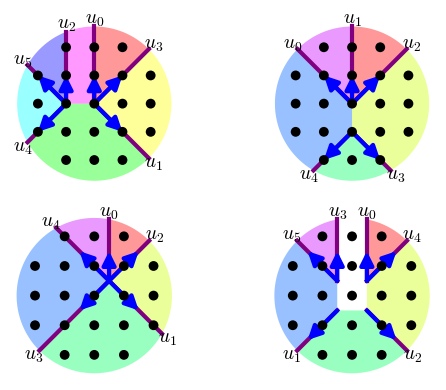

In [37]:
graphics_array([[f.plot(0), f.plot(1)], [f.plot(2), f.plot(-1)]])

In [38]:
print(f.coordinate_ring())

Quotient of Multivariate Polynomial Ring in t0, t1, t2, t3, t4, t5 over Rational Field by the ideal (t0*t1 + t2*t3 + t4^2)


In [39]:
p = [(0,0), (-0.5,0), (-1,0), (0,0), (0,-1), (0.5,0.5)]
r = [(1,-1), (0,-1), (-1,-1), (-1,1), (0,1), (1,1)]

In [40]:
import time
start = time.time()
p1 = Polyhedron([p[0]], [r[4], r[5]])
p2 = Polyhedron([p[0], p[1]], [r[4]])
p3 = Polyhedron([p[0]], [r[5], r[0]])
p4 = Polyhedron([p[0]], [r[0], r[1]])
p5 = Polyhedron([p[0], p[1]], [r[1]])
p6 = Polyhedron([p[1], p[2]], [r[1]])
p7 = Polyhedron([p[2]], [r[1], r[2]])
p8 = Polyhedron([p[2]], [r[2], r[3]])
p9 = Polyhedron([p[2]], [r[3], r[4]])
p10 = Polyhedron([p[1], p[2]], [r[4]])

p11 = Polyhedron([p[3]], [r[4], r[5]])
p12 = Polyhedron([p[3], p[4]], [r[5], r[0]])
p13 = Polyhedron([p[4]], [r[0], r[1]])
p14 = Polyhedron([p[4]], [r[1], r[2]])
p15 = Polyhedron([p[3], p[4]], [r[2], r[3]])
p16 = Polyhedron([p[3]], [r[3], r[4]])

p17 = Polyhedron([p[5]], [r[4], r[5]])
p18 = Polyhedron([p[5]], [r[5], r[0]])
p19 = Polyhedron([p[5]], [r[0], r[1]])
p20 = Polyhedron([p[5]], [r[1], r[2]])
p21 = Polyhedron([p[5]], [r[2], r[3]])
p22 = Polyhedron([p[5]], [r[3], r[4]])
print(time.time()-start)

21.77048659324646


In [41]:
start = time.time()
slice7 = PolyhedralSubdivision([p1,p2,p3,p4,p5,p6,p7,p8, p9, p10])
print(time.time()-start)
start = time.time()
slice8 = PolyhedralSubdivision([p11,p12,p13,p14,p15,p16])
print(time.time()-start)
start = time.time()
slice9 = PolyhedralSubdivision([p17,p18,p19,p20,p21,p22])
print(time.time()-start)

0.011340618133544922
0.0056362152099609375
0.007281064987182617


In [42]:
start = time.time()
f = fDivisor([(1,0), (0,1), (1,1)], [slice7, slice8, slice9])
print(time.time() - start)

0.07587814331054688


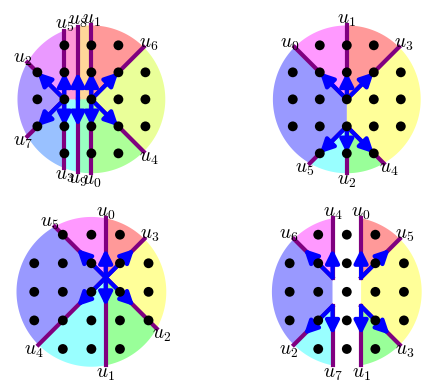

In [43]:
graphics_array([[f.plot(0), f.plot(1)], [f.plot(2), f.plot(-1)]])

In [44]:
print(f.coordinate_ring())

Quotient of Multivariate Polynomial Ring in t0, t1, t2, t3, t4, t5, t6, t7 over Rational Field by the ideal (t0*t1^2*t2 + t3*t4 + t5^2)
